In [122]:
# Import necessary libraries
# - `geopandas` for geographic data manipulation
# - `matplotlib.pyplot` for visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [123]:
# Load the Business Improvement Districts (BIDs) dataset
# `bid_data` includes geographic boundaries of BIDs across NYC.
bid_data = gpd.read_file('../common_files/NYC_BIDS_09112015.csv', encoding='utf-8')

In [124]:
bid_data.head()

,the_geom,Id,OBJECTID_1,OBJECTID_2,Shape_Leng,F_ALL_BIDs,F_ALL_BI_1,F_ALL_BI_2,F_ALL_BI_3,F_ALL_BI_4,F_ALL_BI_6,F_ALL_BI_7,Shape_Le_1,Shape_Ar_1,Year_Found,Shape_Area
0,MULTIPOLYGON (((-73.94296015325146 40.73949166...,0,0,0,0,0,Queens,Long Island City Partnership,0,https://www.longislandcityqueens.com/,0,0,0,0,2005,0
1,MULTIPOLYGON (((-73.89166191549769 40.67759930...,0,0,0,0,0,Brooklyn,Cypress Hills Fulton,0,https://cypresshillsfultonbid.org/,0,0,0,0,2023,0
2,MULTIPOLYGON (((-73.98282323348212 40.73130538...,0,0,1,0,0,Manhattan,Union Square Partnership,892,https://www.unionsquarenyc.org/,3400000,3950623,25744.4695903,1275270.53685,1984,206555.808776
3,MULTIPOLYGON (((-73.9419337956347 40.806137014...,0,0,2,0,0,Manhattan,125th Street,220,https://www.125thstreet.nyc/,1240462,1289475,18167.7930477,982675.507591,1994,159516.90573
4,MULTIPOLYGON (((-73.9188925538744 40.825078988...,0,0,3,0,1,Bronx,161st Street,145,http://www.161bid.com/,1687028,506873,16588.0134708,1303742.08624,2005,211748.007845


In [125]:
# Load the sidewalk dataset
# `sidewalk_data` contains geographic locations of sidewalks across NYC.
sidewalk_data = gpd.read_file('./files/NYC_Planimetric_Database__Sidewalk_20250228.csv', encoding='utf-8')

In [126]:
# load geojson file
kpfui_dev_data = gpd.read_file('./files/kpfui_dev.json')

In [127]:
sidewalk_gdf = gpd.GeoDataFrame(
    sidewalk_data, 
    geometry=gpd.GeoSeries.from_wkt(sidewalk_data['the_geom'])
)

In [128]:
bid_gdf = gpd.GeoDataFrame(
    bid_data,
    geometry=gpd.GeoSeries.from_wkt(bid_data['the_geom']),
)

In [129]:
# Filter for West Village BID
wv_bid = bid_gdf[bid_gdf['F_ALL_BI_2'] == 'West Village']
# Use `explode` to ensure each geometry component is in a separate row, simplifying spatial analysis
exploded_wv_data = wv_bid.explode()

In [130]:
# Similarly explode the sidewalk MultiPolygons
exploded_sidewalk_data = sidewalk_gdf.explode(index_parts=True)

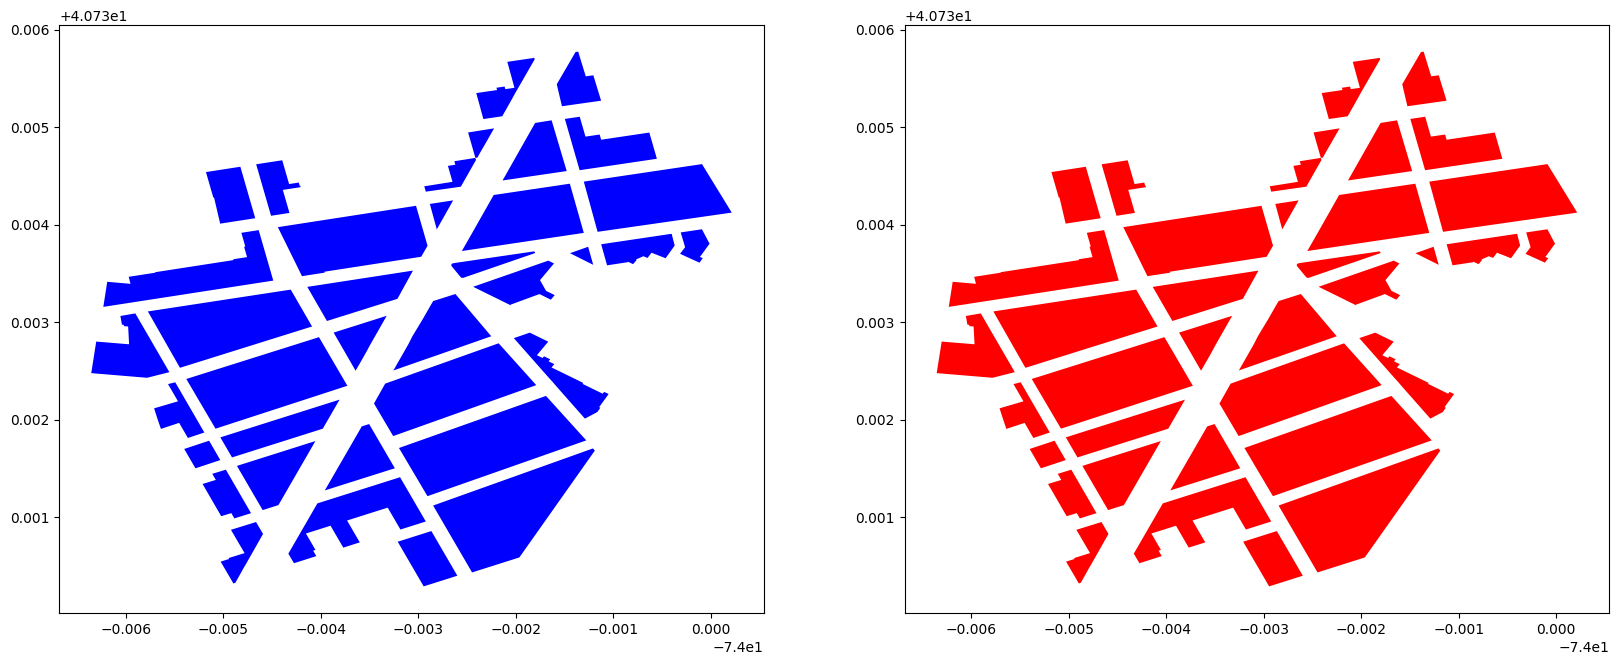

In [131]:
# plot the two datasets side by side
fig, ax = plt.subplots(1, 2,  figsize=(20, 10))

# plot the bid_data_objectid_2_0 geodataframe
wv_bid.plot(ax=ax[0], color='blue', markersize=.01)
# plot the exploded geodataframe
exploded_wv_data.plot(ax=ax[1], color='red', markersize=.01)
exploded_wv_data.set_crs(epsg=4326, inplace=True)
plt.show()

In [132]:
# Create a buffered version of the BID boundaries
# Buffer distance in degrees (for EPSG:4326) - adjust as needed
# ~0.0001 degrees is roughly 10-11 meters at NYC's latitude
buffer_distance = 0.0002 
buffered_wv_data = exploded_wv_data.copy()
buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5840\3212709067.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)


In [133]:
# Spatial join directly without bbox filtering
sidewalks_within_bbox = gpd.sjoin(
    exploded_sidewalk_data, 
    buffered_wv_data, 
    how='inner', 
    predicate='intersects'
)

print("Number of sidewalks found:", len(sidewalks_within_bbox))

Number of sidewalks found: 216


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5840\1289927893.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  sidewalks_within_bbox = gpd.sjoin(


In [134]:
# Spatial join directly without bbox filtering
kpfui_dev_within_bbox = gpd.sjoin(
    kpfui_dev_data, 
    buffered_wv_data, 
    how='inner', 
    predicate='intersects'
)
print("Number of sidewalks found:", len(kpfui_dev_within_bbox))

Number of sidewalks found: 665


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5840\2471821290.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


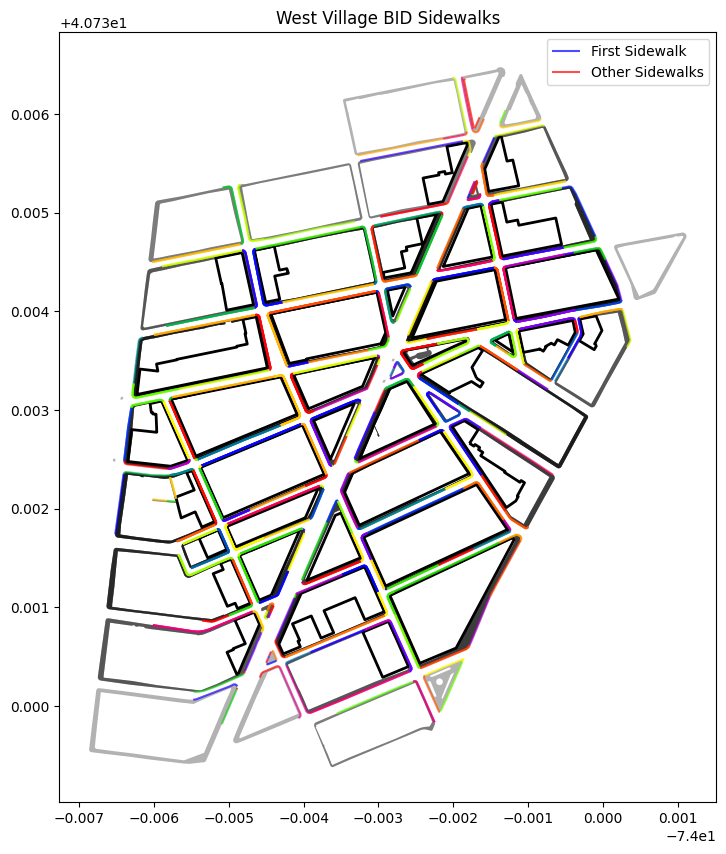

In [135]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the BID boundary
wv_bid.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='BID Boundary')

# Plot the sidewalks
sidewalks_within_bbox.plot(ax=ax, color='black', alpha=0.3, label='Sidewalks')

# Split the sidewalks dataframe into first row and rest
if len(kpfui_dev_within_bbox) > 0:
    first_row = kpfui_dev_within_bbox.iloc[[0]]
    rest_rows = kpfui_dev_within_bbox.iloc[1:] if len(kpfui_dev_within_bbox) > 1 else None
    
    # Plot the first row in blue
    first_row.plot(ax=ax, color='blue', alpha=0.7, label='First Sidewalk')
    
    # Plot the rest in red (if there are any)
    if rest_rows is not None and len(rest_rows) > 0:
        rest_rows.plot(ax=ax, alpha=0.7, label='Other Sidewalks', cmap='prism')
else:
    print("No sidewalks found to plot")

# Add labels and title
plt.title('West Village BID Sidewalks')
plt.legend()

# Show the plot
plt.show()

In [136]:
# Save the processed sidewalk data as GeoJSON
kpfui_dev_within_bbox.to_file("./files/kpfui_dev_within_bbox.json", driver='GeoJSON')

# Save the BID boundary as GeoJSON
wv_bid.to_file("./files/wv_bid.json", driver='GeoJSON')

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [137]:
# Get and display all column names
kpfui_dev_within_bbox.columns

Index(['area', 'p_total_9', 'area_p_9', 'p_walk_9', 'p_queue_9', 'rest_9',
       'supe_9', 'phar_9', 'bank_9', 'offi_9', 'subw_9', 'p_total_12',
       'area_p_12', 'p_walk_12', 'p_queue_12', 'rest_12', 'supe_12', 'phar_12',
       'bank_12', 'offi_12', 'subw_12', 'p_total_19', 'area_p_19', 'p_walk_19',
       'p_queue_19', 'rest_19', 'supe_19', 'phar_19', 'bank_19', 'offi_19',
       'subw_19', 'geometry', 'index_right', 'the_geom', 'Id', 'OBJECTID_1',
       'OBJECTID_2', 'Shape_Leng', 'F_ALL_BIDs', 'F_ALL_BI_1', 'F_ALL_BI_2',
       'F_ALL_BI_3', 'F_ALL_BI_4', 'F_ALL_BI_6', 'F_ALL_BI_7', 'Shape_Le_1',
       'Shape_Ar_1', 'Year_Found', 'Shape_Area'],
      dtype='object')

In [138]:
kpfui_dev_within_bbox.head(1)["geometry"]

1016    LINESTRING (-74.00436 40.73046, -74.00437 40.7...
Name: geometry, dtype: geometry

In [139]:
# Calculate length of each linestring in meters
kpfui_dev_within_bbox_projected = kpfui_dev_within_bbox.copy()

# Ensure CRS is set
if kpfui_dev_within_bbox_projected.crs is None:
    kpfui_dev_within_bbox_projected.set_crs(epsg=4326, inplace=True)

# Project to UTM zone 18N for accurate measurements
kpfui_dev_within_bbox_projected = kpfui_dev_within_bbox_projected.to_crs(epsg=32618)

# Calculate length in meters
kpfui_dev_within_bbox_projected['est_length_m'] = kpfui_dev_within_bbox_projected.geometry.length

# Convert area from sqft to square meters
kpfui_dev_within_bbox_projected['est_area_sqm'] = kpfui_dev_within_bbox_projected['area'] * 0.0929

# Estimate width by dividing area by length
kpfui_dev_within_bbox_projected['est_width_m'] = kpfui_dev_within_bbox_projected['est_area_sqm'] / kpfui_dev_within_bbox_projected['est_length_m']

# Cap the maximum width to a reasonable value (e.g., 10 meters)
# This prevents unrealistic buffers for very short linestrings
max_width = 10.0  # meters
min_width = 1.5   # meters - typical minimum sidewalk width
kpfui_dev_within_bbox_projected['est_width_m'] = kpfui_dev_within_bbox_projected['est_width_m'].clip(lower=min_width, upper=max_width)

# Create polygon representation using buffer with flat end caps
kpfui_dev_within_bbox_projected['sidewalk_polygon'] = kpfui_dev_within_bbox_projected.apply(
    lambda row: row.geometry.buffer(row['est_width_m'] / 2, cap_style=2),  # cap_style=2 for flat ends
    axis=1
)

# Convert to a GeoDataFrame with polygon geometry
sidewalk_polygons = gpd.GeoDataFrame(
    kpfui_dev_within_bbox_projected,
    geometry='sidewalk_polygon',
    crs=kpfui_dev_within_bbox_projected.crs
)

# Display statistics to verify reasonable values
print("Width statistics (meters):")
print(sidewalk_polygons['est_width_m'].describe())

Width statistics (meters):
count    665.000000
mean       3.851517
std        2.818062
min        1.500000
25%        2.068336
50%        2.468582
75%        4.222960
max       10.000000
Name: est_width_m, dtype: float64


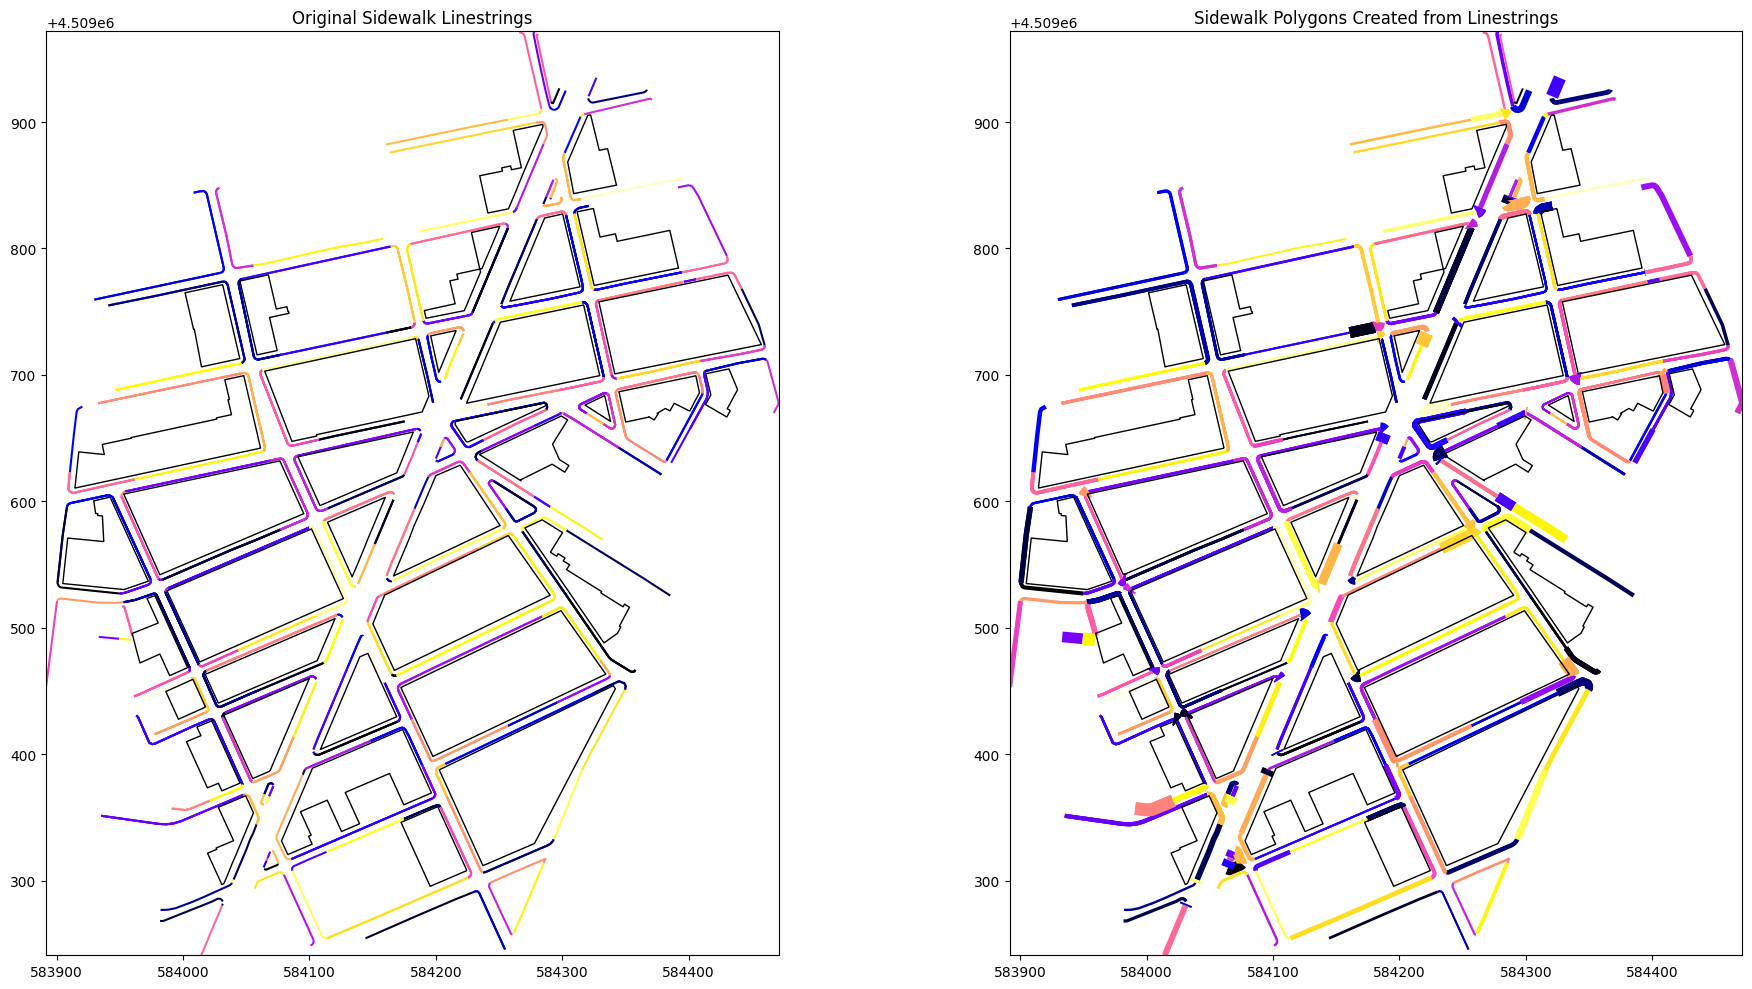

In [140]:
# Visualize the original linestrings and the created polygons
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot original linestrings
kpfui_dev_within_bbox_projected.plot(ax=ax[0], cmap='gnuplot2')
ax[0].set_title('Original Sidewalk Linestrings')

# Plot created polygons
sidewalk_polygons.plot(ax=ax[1], cmap='gnuplot2')
ax[1].set_title('Sidewalk Polygons Created from Linestrings')

# Add BID boundary to both plots for reference - first ensure it has a CRS
if wv_bid.crs is None:
    wv_bid = wv_bid.set_crs(epsg=4326)
    
wv_bid_projected = wv_bid.to_crs(epsg=32618)
wv_bid_projected.boundary.plot(ax=ax[0], color='black', linewidth=1)
wv_bid_projected.boundary.plot(ax=ax[1], color='black', linewidth=1)

# Set the same axis limits for both plots to ensure proper comparison
ax[0].set_xlim([kpfui_dev_within_bbox_projected.total_bounds[0], kpfui_dev_within_bbox_projected.total_bounds[2]])
ax[0].set_ylim([kpfui_dev_within_bbox_projected.total_bounds[1], kpfui_dev_within_bbox_projected.total_bounds[3]])
ax[1].set_xlim([kpfui_dev_within_bbox_projected.total_bounds[0], kpfui_dev_within_bbox_projected.total_bounds[2]])
ax[1].set_ylim([kpfui_dev_within_bbox_projected.total_bounds[1], kpfui_dev_within_bbox_projected.total_bounds[3]])

plt.tight_layout()
plt.show()

In [141]:
kpfui_dev_polygons = sidewalk_polygons.to_crs(epsg=4326)
kpfui_dev_polygons.columns


Index(['area', 'p_total_9', 'area_p_9', 'p_walk_9', 'p_queue_9', 'rest_9',
       'supe_9', 'phar_9', 'bank_9', 'offi_9', 'subw_9', 'p_total_12',
       'area_p_12', 'p_walk_12', 'p_queue_12', 'rest_12', 'supe_12', 'phar_12',
       'bank_12', 'offi_12', 'subw_12', 'p_total_19', 'area_p_19', 'p_walk_19',
       'p_queue_19', 'rest_19', 'supe_19', 'phar_19', 'bank_19', 'offi_19',
       'subw_19', 'geometry', 'index_right', 'the_geom', 'Id', 'OBJECTID_1',
       'OBJECTID_2', 'Shape_Leng', 'F_ALL_BIDs', 'F_ALL_BI_1', 'F_ALL_BI_2',
       'F_ALL_BI_3', 'F_ALL_BI_4', 'F_ALL_BI_6', 'F_ALL_BI_7', 'Shape_Le_1',
       'Shape_Ar_1', 'Year_Found', 'Shape_Area', 'est_length_m',
       'est_area_sqm', 'est_width_m', 'sidewalk_polygon'],
      dtype='object')

In [142]:
# change to ft
kpfui_dev_polygons["est_width_ft"] = kpfui_dev_polygons["est_width_m"] * 3.28084
kpfui_dev_polygons["est_length_ft"] = kpfui_dev_polygons["est_length_m"] * 3.28084
kpfui_dev_polygons["est_area_ft"] = kpfui_dev_polygons["est_width_ft"] * kpfui_dev_polygons["est_length_ft"]
kpfui_dev_polygons["est_area_p_9"] = kpfui_dev_polygons["est_area_ft"] / kpfui_dev_polygons["p_total_9"]
kpfui_dev_polygons["est_area_p_12"] = kpfui_dev_polygons["est_area_ft"] / kpfui_dev_polygons["p_total_12"]
kpfui_dev_polygons["est_area_p_19"] = kpfui_dev_polygons["est_area_ft"] / kpfui_dev_polygons["p_total_19"]

# For each column that might contain Infinity
for col in ['est_area_p_9', 'est_area_p_12', 'est_area_p_19']:    
    # Or replace with a maximum value
    kpfui_dev_polygons[col] = kpfui_dev_polygons[col].replace([np.inf, -np.inf], 3000)

In [143]:
kpfui_dev_polygons["area"].describe()

count     665.000000
mean     1504.980156
std       775.071422
min        16.040000
25%       988.541000
50%      1369.727000
75%      1835.878000
max      4639.119000
Name: area, dtype: float64

In [144]:
kpfui_dev_polygons["est_area_ft"].describe()

count     665.000000
mean     1399.261556
std       802.896833
min         6.076127
25%       888.319988
50%      1300.138538
75%      1804.197076
max      4638.967494
Name: est_area_ft, dtype: float64

In [145]:
kpfui_dev_polygons["area_p_9"].describe()

count     665.000000
mean      101.944710
std       207.847054
min         0.121000
25%        34.080000
50%        59.211000
75%       106.809000
max      2714.942000
Name: area_p_9, dtype: float64

In [146]:
kpfui_dev_polygons["polygon_id"] = range(len(kpfui_dev_polygons))

In [147]:
kpfui_dev_polygons.columns

Index(['area', 'p_total_9', 'area_p_9', 'p_walk_9', 'p_queue_9', 'rest_9',
       'supe_9', 'phar_9', 'bank_9', 'offi_9', 'subw_9', 'p_total_12',
       'area_p_12', 'p_walk_12', 'p_queue_12', 'rest_12', 'supe_12', 'phar_12',
       'bank_12', 'offi_12', 'subw_12', 'p_total_19', 'area_p_19', 'p_walk_19',
       'p_queue_19', 'rest_19', 'supe_19', 'phar_19', 'bank_19', 'offi_19',
       'subw_19', 'geometry', 'index_right', 'the_geom', 'Id', 'OBJECTID_1',
       'OBJECTID_2', 'Shape_Leng', 'F_ALL_BIDs', 'F_ALL_BI_1', 'F_ALL_BI_2',
       'F_ALL_BI_3', 'F_ALL_BI_4', 'F_ALL_BI_6', 'F_ALL_BI_7', 'Shape_Le_1',
       'Shape_Ar_1', 'Year_Found', 'Shape_Area', 'est_length_m',
       'est_area_sqm', 'est_width_m', 'sidewalk_polygon', 'est_width_ft',
       'est_length_ft', 'est_area_ft', 'est_area_p_9', 'est_area_p_12',
       'est_area_p_19', 'polygon_id'],
      dtype='object')

In [148]:
# Create a new GeoDataFrame with only the polygon geometry
sidewalk_polygons_for_export = gpd.GeoDataFrame(
    kpfui_dev_polygons.drop(columns=['geometry', 'the_geom', 'sidewalk_polygon']), 
    # Use only the sidewalk_polygon as the geometry
    geometry=sidewalk_polygons['sidewalk_polygon'],
    crs=sidewalk_polygons.crs
)
print(sidewalk_polygons_for_export.columns)
# Convert to WGS84 for standard GeoJSON compatibility
sidewalk_polygons_for_export = sidewalk_polygons_for_export.to_crs(epsg=4326)

# Save to GeoJSON
sidewalk_polygons_for_export.to_file("./files/kpfui_dev_polygons.json", driver='GeoJSON')

# Verify the file was created successfully
print(f"File saved successfully with {len(sidewalk_polygons_for_export)} polygons")

Index(['area', 'p_total_9', 'area_p_9', 'p_walk_9', 'p_queue_9', 'rest_9',
       'supe_9', 'phar_9', 'bank_9', 'offi_9', 'subw_9', 'p_total_12',
       'area_p_12', 'p_walk_12', 'p_queue_12', 'rest_12', 'supe_12', 'phar_12',
       'bank_12', 'offi_12', 'subw_12', 'p_total_19', 'area_p_19', 'p_walk_19',
       'p_queue_19', 'rest_19', 'supe_19', 'phar_19', 'bank_19', 'offi_19',
       'subw_19', 'index_right', 'Id', 'OBJECTID_1', 'OBJECTID_2',
       'Shape_Leng', 'F_ALL_BIDs', 'F_ALL_BI_1', 'F_ALL_BI_2', 'F_ALL_BI_3',
       'F_ALL_BI_4', 'F_ALL_BI_6', 'F_ALL_BI_7', 'Shape_Le_1', 'Shape_Ar_1',
       'Year_Found', 'Shape_Area', 'est_length_m', 'est_area_sqm',
       'est_width_m', 'est_width_ft', 'est_length_ft', 'est_area_ft',
       'est_area_p_9', 'est_area_p_12', 'est_area_p_19', 'polygon_id',
       'geometry'],
      dtype='object')
File saved successfully with 665 polygons
